---
layout: single
title: 'Calculating slope and aspect from a digital elevation model in Python'
date: 2016-07-26
authors: [Matt Oakley, Max Joseph]
category: [tutorials]
excerpt: 'This tutorial shows how to compute the slope and aspect from a digital elevation model in Python.'
sidebar:
  nav:
author_profile: false
comments: true
lang: [python]
lib: [matplotlib, numpy, elevation, richdem]
---

Digital elevation models (DEM) provide a representaion of surface topography (elevation) in two dimensional space. DEMs are a 3D representaion of a terrain's surface such as the Earth. Typically, DEM data can be represented as a raster which is most easily expressed as being a 2D array with each individual cell having an elevation associated with it. 

With this data, we are able to use programs in order to analyze certain physical aspects about the area associated with the data. This tutorial will go over how we compute the **slope** and **aspect** of an area using DEM data.

## Objectives

- Read in DEM data
- Compute the slope for the entirety of the data
- Compute the aspect for the entirety of the data
- Plot the slope of the terrain
- Plot the aspect of the terrain

## Dependencies

- numpy
- matplotlib
- elevation
- richdem

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import elevation
import richdem as rd

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 5.5)

## Download a digital elevation model

The `elevation` module provides access to elevation data from the NASA SRTM mission, with areas of interest specified via a bounding box. Here we draw a bounding box around Mt. Shasta in northern California, and use the command line interface to output a GeoTIFF. 

In [3]:
elevation.clip(bounds=(-122.4, 41.2, -122.1, 41.5), output='Shasta-30m-DEM.tif')

## Load the DEM with richdem

The `richdem` package has a `LoadGDAL` function for loading DEMs that we can use here. 

In [4]:
shasta_dem = rd.LoadGDAL("Shasta-30m-DEM.tif")

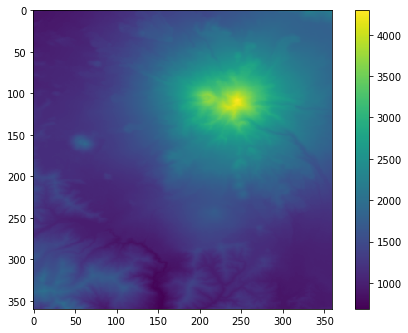

In [5]:
plt.imshow(shasta_dem, interpolation='none')
plt.colorbar()
plt.show()

## Compute and plot slope and aspect

We can use the `rd.TerrainAttribute` function to compute slope and aspect for each pixel. Note that there are multiple ways to represent the slope values. See https://richdem.readthedocs.io/en/latest/python_api.html#richdem.TerrainAttribute for more options.

To visualize slope and aspect, we can use the `rdShow` function. 

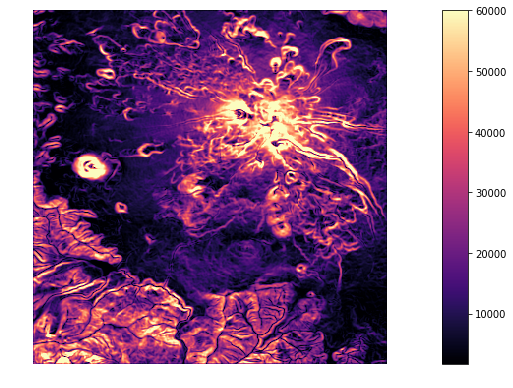

In [6]:
slope = rd.TerrainAttribute(shasta_dem, attrib='slope_riserun')
rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

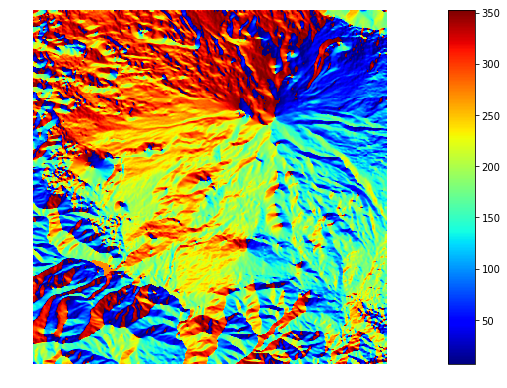

In [7]:
aspect = rd.TerrainAttribute(shasta_dem, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()